In [1]:
import numpy as np
import os
import pandas as pd

In [2]:
movies_data_path = os.path.join(os.path.pardir, 'data/processed_data.csv') 
movies_data = pd.read_csv(movies_data_path)

In [3]:
movies_data['release_date'] = pd.to_datetime(movies_data['release_date'])
movies_data['day_of_year'] = movies_data['release_date'].dt.day_of_year
movies_data['day_of_year_sin'] = np.sin(2 * np.pi * movies_data['day_of_year'] / 365)
movies_data['day_of_year_cos'] = np.cos(2 * np.pi * movies_data['day_of_year'] / 365) 
movies_data['year'] = movies_data['release_date'].dt.year
movies_data['year'] = (movies_data['year'] - movies_data['year'].mean()) / movies_data['year'].std() 

In [4]:
path_ratings = os.path.join(os.path.pardir, 'data/ratings.csv')
ratings_df = pd.read_csv(path_ratings)

ratings = ratings_df['rating'].to_numpy()
movieId_of_rating = ratings_df['movieId'].to_numpy()
movie_ids = set(ratings_df['movieId'].unique().tolist())

In [5]:
movies_data = movies_data[movies_data['movieId'].isin(movie_ids)]
movies_indices = movies_data['movieId'].to_numpy()
movies_data.drop(columns=['Unnamed: 0', 'index', 'movieId', 'release_date', 'day_of_year', 'count'], inplace=True)

A = movies_data.to_numpy()

In [6]:
movies_data.head()

,budget,popularity,revenue,runtime,video,vote_average,vote_count,Music,Sentai Filmworks,Animation,...,max_rating_by_main_character_1,min_rating_by_main_character_1,mean_rating_by_main_character_2,max_rating_by_main_character_2,min_rating_by_main_character_2,mean_rating_by_prod_company,ratio_benefit,day_of_year_sin,day_of_year_cos,year
0,0.216912,0.335964,-0.174219,0.728011,-0.045235,0.146495,-0.068832,-0.190816,-0.004686,-0.211216,...,0.549688,-0.578246,3.443951,0.553555,-0.583511,-0.918523,-0.092618,0.635432,0.772157,0.337414
1,11.243154,2.981965,6.593328,0.388473,-0.045235,0.146495,4.211206,-0.190816,-0.004686,-0.211216,...,0.549688,-0.578246,2.686671,0.553555,-0.583511,-0.918523,-0.092617,-0.008607,-0.999963,0.462114
2,-0.242515,1.355923,-0.174219,1.903336,-0.045235,1.081932,0.517865,-0.190816,-0.004686,-0.211216,...,0.549688,-0.578246,2.634840,0.553555,-0.583511,-0.918523,-0.092618,0.981306,0.192452,-0.826452
3,-0.242515,0.490496,-0.174219,-0.212249,-0.045235,0.926026,0.218405,-0.190816,-0.004686,-0.211216,...,0.549688,-0.578246,2.576529,0.553555,-0.583511,-0.918523,-0.092618,0.501242,-0.865307,-2.364418
4,-0.242515,1.283564,-0.174219,0.519064,-0.045235,0.614213,-0.103464,-0.190816,-0.004686,-0.211216,...,0.549688,-0.578246,1.196496,0.553555,-0.583511,-0.918523,-0.092618,-0.854322,-0.519744,0.378981


## <font color='red'> <div align='center'> I will first experiment with 100 movies and 50 features </font></div>

In [12]:
from utils import sample_k_movies
from MAB_class import MABAgent, LinUCB_MABAgent


# Let start with just 10 movies

k = 100
m = 50
lambda_ = 1
movies_id_k = movies_indices[:k]
mask = [i for i in range(movieId_of_rating.size) if movieId_of_rating[i] in movies_id_k]
movieId_of_rating_k = movieId_of_rating[mask]
ratings_k = ratings[mask]


A_100 = sample_k_movies(A, k, m)
delta = 0.02
epsilon = 0.5
n_rounds = 100000
true_rewards = ratings_k
rewardsXmovie_indices = movieId_of_rating_k 
actionXmovie_indices = movies_id_k


Agent_Optimal = MABAgent(A_100, delta, epsilon, n_rounds, true_rewards, rewardsXmovie_indices, actionXmovie_indices)
Agent_LinUCB = LinUCB_MABAgent(A_100, delta, lambda_, 5*n_rounds, true_rewards, rewardsXmovie_indices, actionXmovie_indices)

In [8]:
cumulative_regret, regret, theta = Agent_Optimal.run()
cumulative_regret_linUCB, regret_linUCB, theta_linUCB = Agent_LinUCB.run()

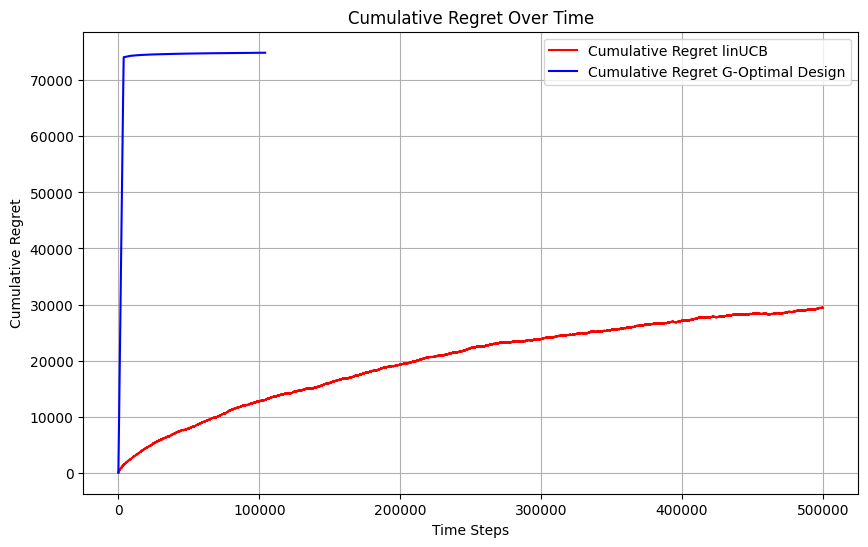

In [22]:
import matplotlib.pyplot as plt

time_steps = range(len(cumulative_regret))  # Assuming each entry corresponds to a time step
time_steps_linUCB = range(len(cumulative_regret_linUCB))  # Assuming each entry corresponds to a time step

# Plotting  
plt.figure(figsize=(10, 6))
plt.plot(time_steps_linUCB, cumulative_regret_linUCB, linestyle='-', color='r', label='Cumulative Regret linUCB')
plt.plot(time_steps, cumulative_regret, linestyle='-', color='b', label='Cumulative Regret G-Optimal Design')

# Customizing the plot
plt.title('Cumulative Regret Over Time')
plt.xlabel('Time Steps')
plt.ylabel('Cumulative Regret')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

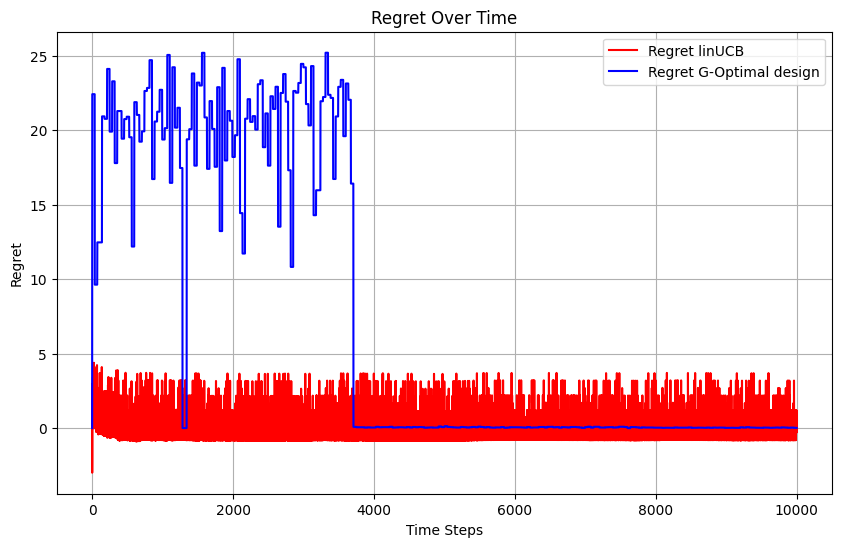

In [24]:
import matplotlib.pyplot as plt

time_steps_linUCB = range(len(cumulative_regret_linUCB))  # Assuming each entry corresponds to a time step

# Plotting  
plt.figure(figsize=(10, 6))
plt.plot(time_steps_linUCB[:10000], regret_linUCB[:10000], linestyle='-', color='r', label='Regret linUCB')
plt.plot(time_steps[:10000], regret[:10000], linestyle='-', color='b', label='Regret G-Optimal design')

# Customizing the plot
plt.title('Regret Over Time')
plt.xlabel('Time Steps')
plt.ylabel('Regret')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

## Conclusion

It’s evident that **linUCB** significantly outperforms the **G-optimal design** across the tested dimensions. Throughout the evaluation period, the regret for linUCB remains relatively small, while the G-optimal design exhibits a sharp increase in regret from the outset.

### Key Observations:
- **linUCB** maintains consistent performance due to its efficient exploration strategy.
- The **G-optimal design** suffers early regret due to its comprehensive exploration of all examples, which is particularly detrimental in the initial stages with limited data.

In summary, linUCB's more adaptive exploration approach provides a clear advantage in scenarios where data is sparse, making it a superior choice for managing regret effectively.


## <font color='red'> <div align='center'> Let experiment with 20 movies and 20 features </font></div>

In [7]:
from utils import sample_k_movies
from MAB_class import MABAgent, LinUCB_MABAgent


# Let start with just 10 movies

k = 20
m = 20
lambda_ = 1
movies_id_k = movies_indices[:k]
mask = [i for i in range(movieId_of_rating.size) if movieId_of_rating[i] in movies_id_k]
movieId_of_rating_k = movieId_of_rating[mask]
ratings_k = ratings[mask]


A_20 = sample_k_movies(A, k, m)
delta = 0.02
epsilon = 0.5
n_rounds = 100000
true_rewards = ratings_k
rewardsXmovie_indices = movieId_of_rating_k 
actionXmovie_indices = movies_id_k


Agent_Optimal = MABAgent(A_20, delta, epsilon, n_rounds, true_rewards, rewardsXmovie_indices, actionXmovie_indices)
Agent_LinUCB = LinUCB_MABAgent(A_20, delta, lambda_, n_rounds, true_rewards, rewardsXmovie_indices, actionXmovie_indices)

In [8]:
cumulative_regret, regret, theta = Agent_Optimal.run()
cumulative_regret_linUCB, regret_linUCB, theta_linUCB = Agent_LinUCB.run()

In [ ]:
import matplotlib.pyplot as plt

time_steps = range(len(cumulative_regret))  # Assuming each entry corresponds to a time step
time_steps_linUCB = range(len(cumulative_regret_linUCB))  # Assuming each entry corresponds to a time step

# Plotting  
plt.figure(figsize=(10, 6))
plt.plot(time_steps_linUCB, cumulative_regret_linUCB, linestyle='-', color='r', label='Cumulative Regret linUCB')
plt.plot(time_steps, cumulative_regret, linestyle='-', color='b', label='Cumulative Regret G-Optimal Design')

# Customizing the plot
plt.title('Cumulative Regret Over Time')
plt.xlabel('Time Steps')
plt.ylabel('Cumulative Regret')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt

time_steps_linUCB = range(len(cumulative_regret_linUCB))  # Assuming each entry corresponds to a time step

# Plotting  
plt.figure(figsize=(10, 6))
plt.plot(time_steps_linUCB[:10000], regret_linUCB[:10000], linestyle='-', color='r', label='Regret linUCB')
plt.plot(time_steps[:10000], regret[:10000], linestyle='-', color='b', label='Regret G-Optimal design')

# Customizing the plot
plt.title('Regret Over Time')
plt.xlabel('Time Steps')
plt.ylabel('Regret')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()